In [1]:
from drone_detector.utils import * 
from drone_detector.imports import *
import rasterio.mask as rio_mask
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings("ignore")
sys.path.append('..')
from src.tree_functions import *

# Comparison of plot characteristics and results

Here we first compare the annotations and predictions in field plot level metrics, and then do the same for predictions and field data. Comparison between annotations and predictions is done with all data within the virtual plot, whereas the comparisons between predictions and field data are done with the predictions intersecting the field plot circle.

# Hiidenportti

Read data and do some wrangling. Hiidenportti data comparisons are done only with five test virtual plots.

In [3]:
field_data_path = Path('../data/hiidenportti')
anns = gpd.read_file('../../data/raw/hiidenportti/virtual_plots/all_deadwood_hiidenportti.geojson')
preds = gpd.read_file('../results/hiidenportti/merged_all.geojson')
plot_circles = gpd.read_file(field_data_path/'plot_circles.geojson')
field_data = pd.read_csv(field_data_path/'all_plot_data.csv')
virtual_plot_grid = gpd.read_file(field_data_path/'envelopes_with_trees.geojson')
natura_areas = gpd.read_file(field_data_path/'hiidenportti_natura.geojson')

Filter plot circles so that only those present in virtual plots remain.

In [4]:
plot_circles['in_vplot'] = plot_circles.apply(lambda row: 1 if any(virtual_plot_grid.geometry.contains(row.geometry)) 
                                              else 0, axis=1)
plot_circles['id'] = plot_circles['id'].astype(int)
field_data = field_data[field_data.id.isin(plot_circles[plot_circles.in_vplot==1].id.unique())]
field_data.rename(columns= {c: c.replace('.','_') for c in field_data.columns}, inplace=True)
dw_cols = ['id'] + [c for c in field_data.columns if 'dw' in c]
plot_dw_data = field_data[dw_cols].copy()

In [5]:
plot_circles = plot_circles[plot_circles.in_vplot == 1]

Convert `n_dw` (number of deadwood stems per hectare), `n_ddw` and `n_udw` to signify number of deadwood stems in circular plot with 9m radius.

In [6]:
plot_dw_data['n_dw_plot'] = np.round((plot_dw_data['n_dw']/10000)*np.pi*9**2).astype(int)
plot_dw_data['n_ddw_plot'] = np.round((plot_dw_data['n_ddw']/10000)*np.pi*9**2).astype(int)
plot_dw_data['n_udw_plot'] = plot_dw_data.n_dw_plot - plot_dw_data.n_ddw_plot

Some helper functions for data matching.

In [7]:
def match_circular_plot(row, plots):
    "Match annotations with field plots"
    for p in plots.itertuples():
        if row.geometry.intersects(p.geometry):
            return int(p.id)
        
def match_vplot(row, plots):
    "Match annotations with field plots"
    for p in plots.itertuples():
        if row.geometry.intersects(p.geometry):
            return f'{p.id}_{p.level_1}'

In [8]:
anns['plot_id'] = anns.apply(lambda row: match_circular_plot(row, plot_circles), axis=1)
anns_in_plots = anns[anns.geometry.intersects(plot_circles.geometry.unary_union)].copy()
anns_in_plots['plot_id'] = anns_in_plots.plot_id.astype(int)

Add relevant information to predictions.

In [9]:
preds['conservation'] = preds.geometry.apply(lambda row: 1 if any(natura_areas.geometry.contains(row))
                                                         else 0)

In [10]:
preds['plot_id'] = preds.apply(lambda row: match_circular_plot(row, plot_circles), axis=1)
preds_in_plots = preds[preds.geometry.intersects(plot_circles.geometry.unary_union)].copy()
preds_in_plots['plot_id'] = preds_in_plots.plot_id.astype(int)
preds['vplot_id'] = preds.apply(lambda row: match_vplot(row, virtual_plot_grid), axis=1)

Filter only test areas

In [11]:
anns_in_plots = anns_in_plots[anns_in_plots.plot_id.isin(preds_in_plots.plot_id.unique())]
plot_dw_data = plot_dw_data[plot_dw_data.id.isin(preds_in_plots.plot_id.unique())]
anns = anns[anns.vplot_id.isin(preds.vplot_id.unique())]

## Predictions vs annotations, with all data present in virtual plots

First crosstab the numbers of different deadwood types.

In [12]:
pd.crosstab(anns.conservation, anns.layer, margins=True)

layer,groundwood,uprightwood,All
conservation,,,
0,546,88,634
1,717,196,913
All,1263,284,1547


In [13]:
pd.crosstab(preds.conservation, preds.layer, margins=True)

layer,groundwood,uprightwood,All
conservation,,,
0,742,87,829
1,923,171,1094
All,1665,258,1923


Add tree length and diameter estimations.

In [14]:
anns['tree_length'] = anns.geometry.apply(get_len)
preds['tree_length'] = preds.geometry.apply(get_len)
anns['diam'] = anns.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000
preds['diam'] = preds.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000

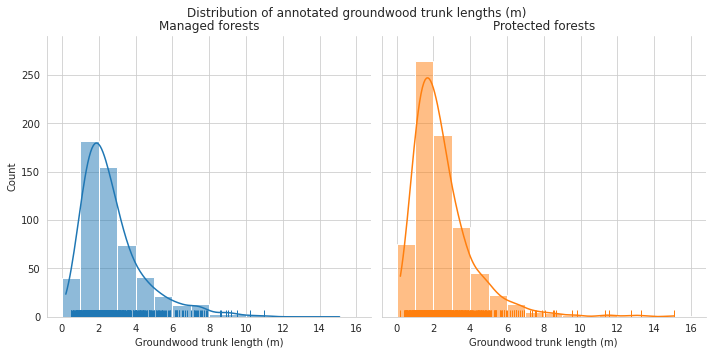

In [15]:
g = sns.displot(data=anns[anns.layer=='groundwood'], x='tree_length',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=1, binrange=(0, max(anns.tree_length))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood trunk lengths (m)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk length (m)')
plt.show()

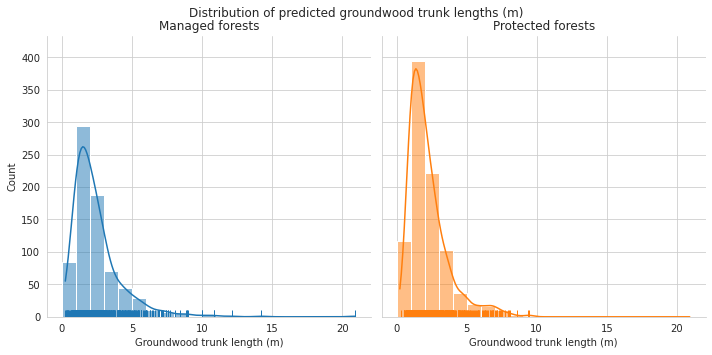

In [16]:
g = sns.displot(data=preds[preds.layer=='groundwood'], x='tree_length',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=1, binrange=(0, max(preds.tree_length))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of predicted groundwood trunk lengths (m)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk length (m)')
plt.show()

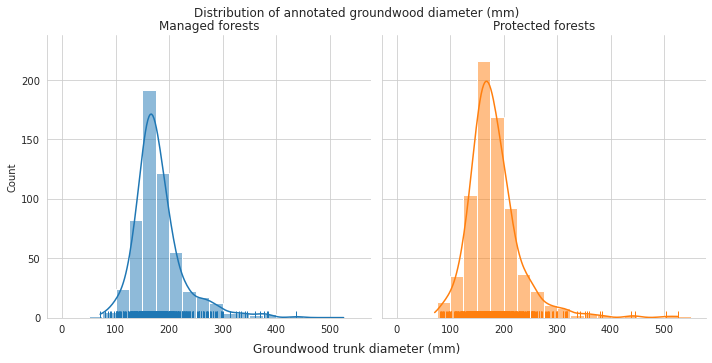

In [17]:
g = sns.displot(data=anns[(anns.layer=='groundwood')], x='diam',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=25, binrange=(0, max(anns[(anns.layer=='groundwood')].diam)))
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood diameter (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('','')
g.fig.supxlabel('Groundwood trunk diameter (mm)')
plt.show()

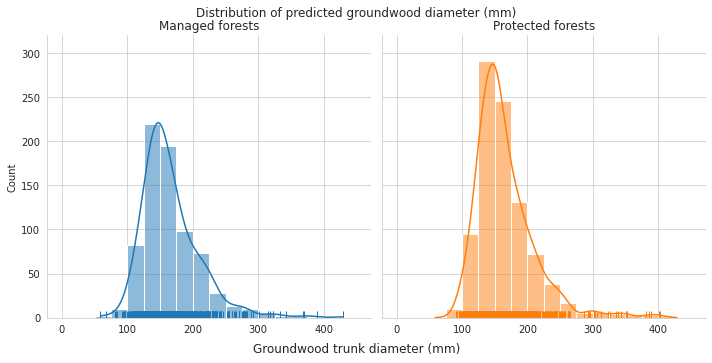

In [18]:
g = sns.displot(data=preds[(preds.layer=='groundwood')], x='diam',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=25, binrange=(0, max(preds[(preds.layer=='groundwood')].diam)))
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of predicted groundwood diameter (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('','')
g.fig.supxlabel('Groundwood trunk diameter (mm)')
plt.show()

In [113]:
anns[anns.layer=='groundwood'].pivot_table(index='conservation', values=['diam', 'tree_length'], 
                                           margins=True, aggfunc=['mean', 'min', 'max'])

mean                    min                     max  \
                    diam tree_length       diam tree_length        diam   
conservation                                                              
0             179.679196    2.728391  71.154254    0.470090  437.519765   
1             181.523696    2.515415  81.119568    0.206041  526.190594   
All           180.726311    2.607485  71.154254    0.206041  526.190594   

                          
             tree_length  
conservation              
0              10.976927  
1              15.087245  
All            15.087245

In [114]:
preds[preds.layer=='groundwood'].pivot_table(index='conservation', values=['diam', 'tree_length'], 
                                           margins=True, aggfunc=['mean', 'min', 'max'])

mean                    min                     max  \
                    diam tree_length       diam tree_length        diam   
conservation                                                              
0             165.626210    2.452524  58.568868    0.233497  428.922030   
1             165.067576    2.242332  90.831901    0.282261  402.741579   
All           165.316529    2.336003  58.568868    0.233497  428.922030   

                          
             tree_length  
conservation              
0              20.916895  
1               9.481155  
All            20.916895

In [21]:
anns['area_m2'] = anns.geometry.area
preds['area_m2'] = preds.geometry.area

In [22]:
anns[anns.layer=='uprightwood'].pivot_table(index='conservation', values=['area_m2'], margins=True,
                                            aggfunc=['mean', 'sum'])

,mean,sum
,area_m2,area_m2
conservation,,
0,3.487542,306.903714
1,2.653700,520.125206
All,2.912074,827.028920


In [23]:
preds[preds.layer=='uprightwood'].pivot_table(index='conservation', values=['area_m2'], margins=True,
                                              aggfunc=['mean', 'sum'])

,mean,sum
,area_m2,area_m2
conservation,,
0,3.095618,269.318808
1,2.817445,481.783174
All,2.911248,751.101982


In [24]:
anns['v_ddw'] = anns.geometry.apply(cut_cone_volume)
preds['v_ddw'] = preds.geometry.apply(cut_cone_volume)

In [25]:
virtual_plot_grid['vplot_id'] = virtual_plot_grid.apply(lambda p: f'{p.id}_{p.level_1}', axis=1)

test_natura_areas = natura_areas.overlay(virtual_plot_grid[virtual_plot_grid.vplot_id.isin(preds.vplot_id.unique())])

test_vplot_area = virtual_plot_grid[virtual_plot_grid.vplot_id.isin(preds.vplot_id.unique())].area.sum()
test_cons_area = test_natura_areas.area.sum()
test_man_area = test_vplot_area - test_cons_area
test_man_ha = test_man_area / 10000
test_cons_ha = test_cons_area / 10000

In [26]:
ann_est_v_man = anns[(anns.layer=='groundwood')&(anns.conservation==0)].v_ddw.sum()/test_man_ha
ann_est_v_cons = anns[(anns.layer=='groundwood')&(anns.conservation==1)].v_ddw.sum()/test_cons_ha
ann_est_v_test = anns[(anns.layer=='groundwood')].v_ddw.sum()/(test_vplot_area/10000)

In [27]:
pred_est_v_man = preds[(preds.layer=='groundwood')&(preds.conservation==0)].v_ddw.sum()/test_man_ha
pred_est_v_cons = preds[(preds.layer=='groundwood')&(preds.conservation==1)].v_ddw.sum()/test_cons_ha
pred_est_v_test = preds[(preds.layer=='groundwood')].v_ddw.sum()/(test_vplot_area/10000)

In [28]:
print(f'Estimated groundwood volume in managed forests, based on annotations: {ann_est_v_man:.2f} ha/m³')
print(f'Estimated groundwood volume in conserved forests, based on annotations: {ann_est_v_cons:.2f} ha/m³')
print(f'Estimated groundwood volume in both types, based on annotations: {ann_est_v_test:.2f} ha/m³')

Estimated groundwood volume in managed forests, based on annotations: 9.60 ha/m³
Estimated groundwood volume in conserved forests, based on annotations: 15.04 ha/m³
Estimated groundwood volume in both types, based on annotations: 12.14 ha/m³


In [29]:
print(f'Estimated groundwood volume in managed forests, based on predictions: {pred_est_v_man:.2f} ha/m³')
print(f'Estimated groundwood volume in conserved forests, based on predictions: {pred_est_v_cons:.2f} ha/m³')
print(f'Estimated groundwood volume in both types, based on predictions: {pred_est_v_test:.2f} ha/m³')

Estimated groundwood volume in managed forests, based on predictions: 12.08 ha/m³
Estimated groundwood volume in conserved forests, based on predictions: 15.23 ha/m³
Estimated groundwood volume in both types, based on predictions: 13.55 ha/m³


## Predictions vs field data, with only predictions present in field plots

Count the number of annotated deadwood instances in each circular field plot, as well as note which of the circular plots are located in the conserved areas.

In [30]:
plot_dw_data['n_dw_ann'] = plot_dw_data.apply(lambda row: anns_in_plots.plot_id.value_counts()[row.id] 
                                              if row.id in anns_in_plots.plot_id.unique() else 0, axis=1)
plot_dw_data['n_ddw_ann'] = plot_dw_data.apply(lambda row: anns_in_plots[anns_in_plots.groundwood==2].plot_id.value_counts()[row.id] 
                                              if row.id in anns_in_plots[anns_in_plots.groundwood==2].plot_id.unique() else 0, axis=1)
plot_dw_data['n_udw_ann'] = plot_dw_data.apply(lambda row: anns_in_plots[anns_in_plots.groundwood==1].plot_id.value_counts()[row.id] 
                                              if row.id in anns_in_plots[anns_in_plots.groundwood==1].plot_id.unique() else 0, axis=1)
plot_dw_data['geometry'] = plot_dw_data.apply(lambda row: plot_circles[plot_circles.id == row.id].geometry.iloc[0], 
                                              axis=1)
plot_dw_data = gpd.GeoDataFrame(plot_dw_data, crs=plot_circles.crs)
plot_dw_data['conservation'] = plot_dw_data.apply(lambda row: 1 if any(natura_areas.geometry.contains(row.geometry))
                                                  else 0, axis=1)

In [31]:
plot_dw_data['n_dw_pred'] = plot_dw_data.apply(lambda row: preds_in_plots.plot_id.value_counts()[row.id] 
                                              if row.id in preds_in_plots.plot_id.unique() else 0, axis=1)
plot_dw_data['n_ddw_pred'] = plot_dw_data.apply(lambda row: preds_in_plots[preds_in_plots.label==2].plot_id.value_counts()[row.id] 
                                              if row.id in preds_in_plots[preds_in_plots.label==2].plot_id.unique() else 0, axis=1)
plot_dw_data['n_udw_pred'] = plot_dw_data.apply(lambda row: preds_in_plots[preds_in_plots.label==1].plot_id.value_counts()[row.id] 
                                              if row.id in preds_in_plots[preds_in_plots.label==1].plot_id.unique() else 0, axis=1)

In [32]:
plot_dw_data.pivot_table(index='conservation', values=['n_ddw_plot', 'n_udw_plot', 
                                                       'n_ddw_ann', 'n_udw_ann',
                                                       'n_ddw_pred', 'n_udw_pred'], 
                         aggfunc='sum', margins=True)

,n_ddw_ann,n_ddw_plot,n_ddw_pred,n_udw_ann,n_udw_plot,n_udw_pred
conservation,,,,,,
0,22,21,29,6,5,3
1,41,51,46,14,24,12
All,63,72,75,20,29,15


Get plot-wise canopy cover percentage based on LiDAR derived canopy height model as the percentage of plot area with height more than 2 meters.

In [33]:
pcts = []

with rio.open('../../data/raw/hiidenportti/full_mosaics/CHM_Hiidenportti_epsg.tif') as src:
    crs = src.crs
    for row in plot_dw_data.itertuples():
        plot_im, plot_tfm = rio_mask.mask(src, [row.geometry], crop=True)
        pcts.append(plot_im[plot_im > 2].shape[0] / plot_im[plot_im >= 0].shape[0])

In [34]:
plot_dw_data['canopy_cover_pct'] = pcts

Plot the relationship between annotated deadwood and field data.

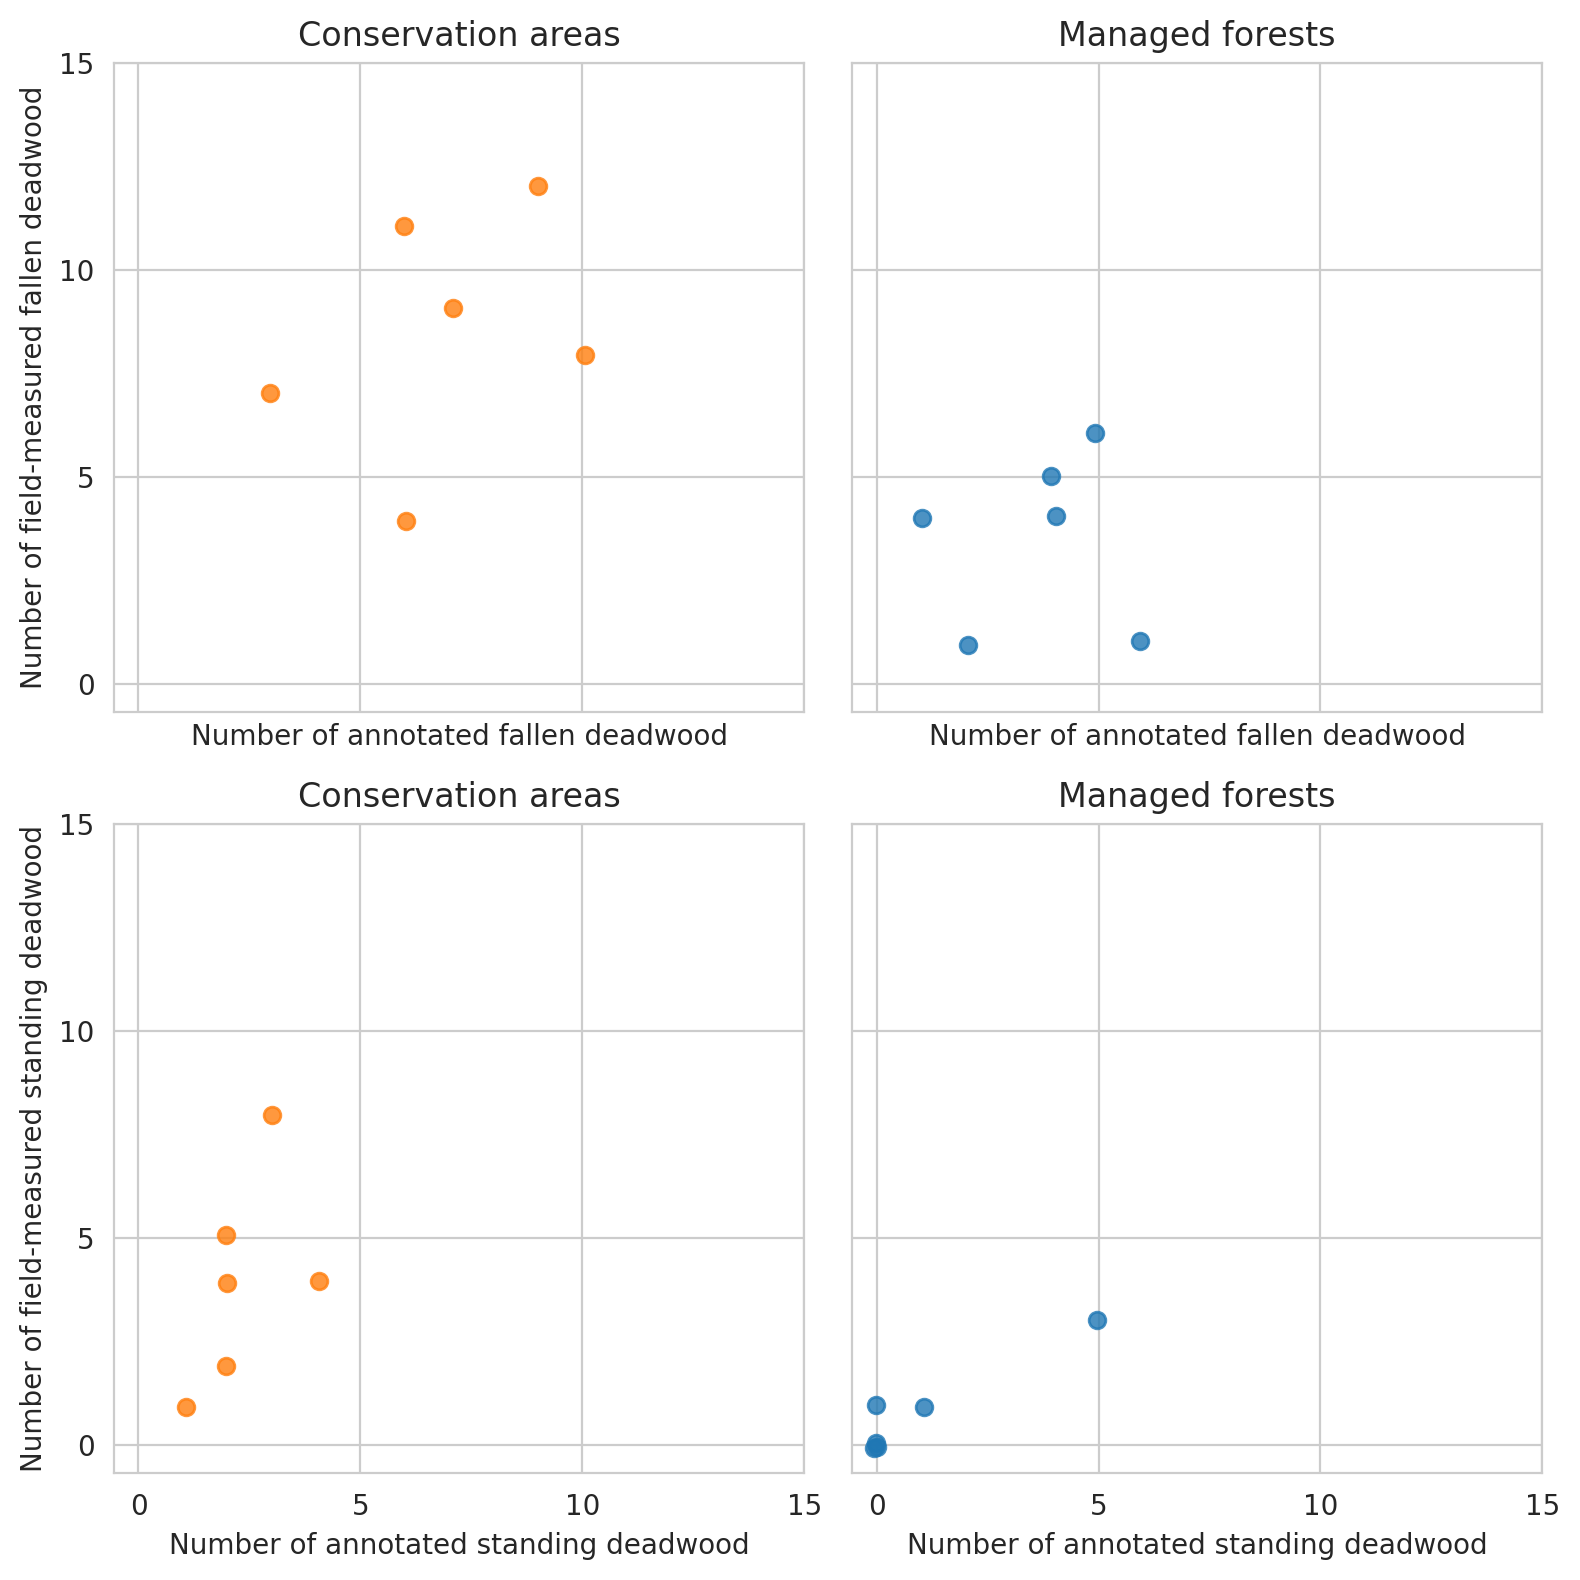

In [35]:
fig, ax = plt.subplots(2,2, figsize=(8,8), dpi=200, sharey=True, sharex=True)
sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 1)], fit_reg=False, 
            x='n_ddw_ann', y='n_ddw_plot', ax=ax[0,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[0,0].set_title('Conservation areas')
ax[0,0].set_yticks(range(0,16,5))
ax[0,0].set_yticklabels(range(0,16,5))
ax[0,0].set_xticks(range(0,16,5))
ax[0,0].set_xticklabels(range(0,16,5))
ax[0,0].set_xlabel('Number of annotated fallen deadwood')
ax[0,0].set_ylabel('Number of field-measured fallen deadwood')
sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 0)], fit_reg=False, 
            x='n_ddw_ann', y='n_ddw_plot', ax=ax[0,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[0,1].set_title('Managed forests')
ax[0,1].set_yticks(range(0,16,5))
ax[0,1].set_yticklabels(range(0,16,5))
ax[0,1].set_xticks(range(0,16,5))
ax[0,1].set_xticklabels(range(0,16,5))
ax[0,1].set_xlabel('Number of annotated fallen deadwood')
ax[0,1].set_ylabel('')


sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 1)], fit_reg=False, 
            x='n_udw_ann', y='n_udw_plot', ax=ax[1,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[1,0].set_title('Conservation areas')
ax[1,0].set_xlabel('Number of annotated standing deadwood')
ax[1,0].set_ylabel('Number of field-measured standing deadwood')
ax[1,0].set_yticks(range(0,16,5))
ax[1,0].set_yticklabels(range(0,16,5))
ax[1,0].set_yticks(range(0,16,5))
ax[1,0].set_yticklabels(range(0,16,5))
sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 0)], fit_reg=False, 
            x='n_udw_ann', y='n_udw_plot', ax=ax[1,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[1,1].set_title('Managed forests')
ax[1,1].set_xlabel('Number of annotated standing deadwood')
ax[1,1].set_ylabel('')
ax[1,1].set_yticks(range(0,16,5))
ax[1,1].set_yticklabels(range(0,16,5))
ax[1,1].set_xticks(range(0,16,5))
ax[1,1].set_xticklabels(range(0,16,5))
plt.tight_layout()

Same for field data and predictions

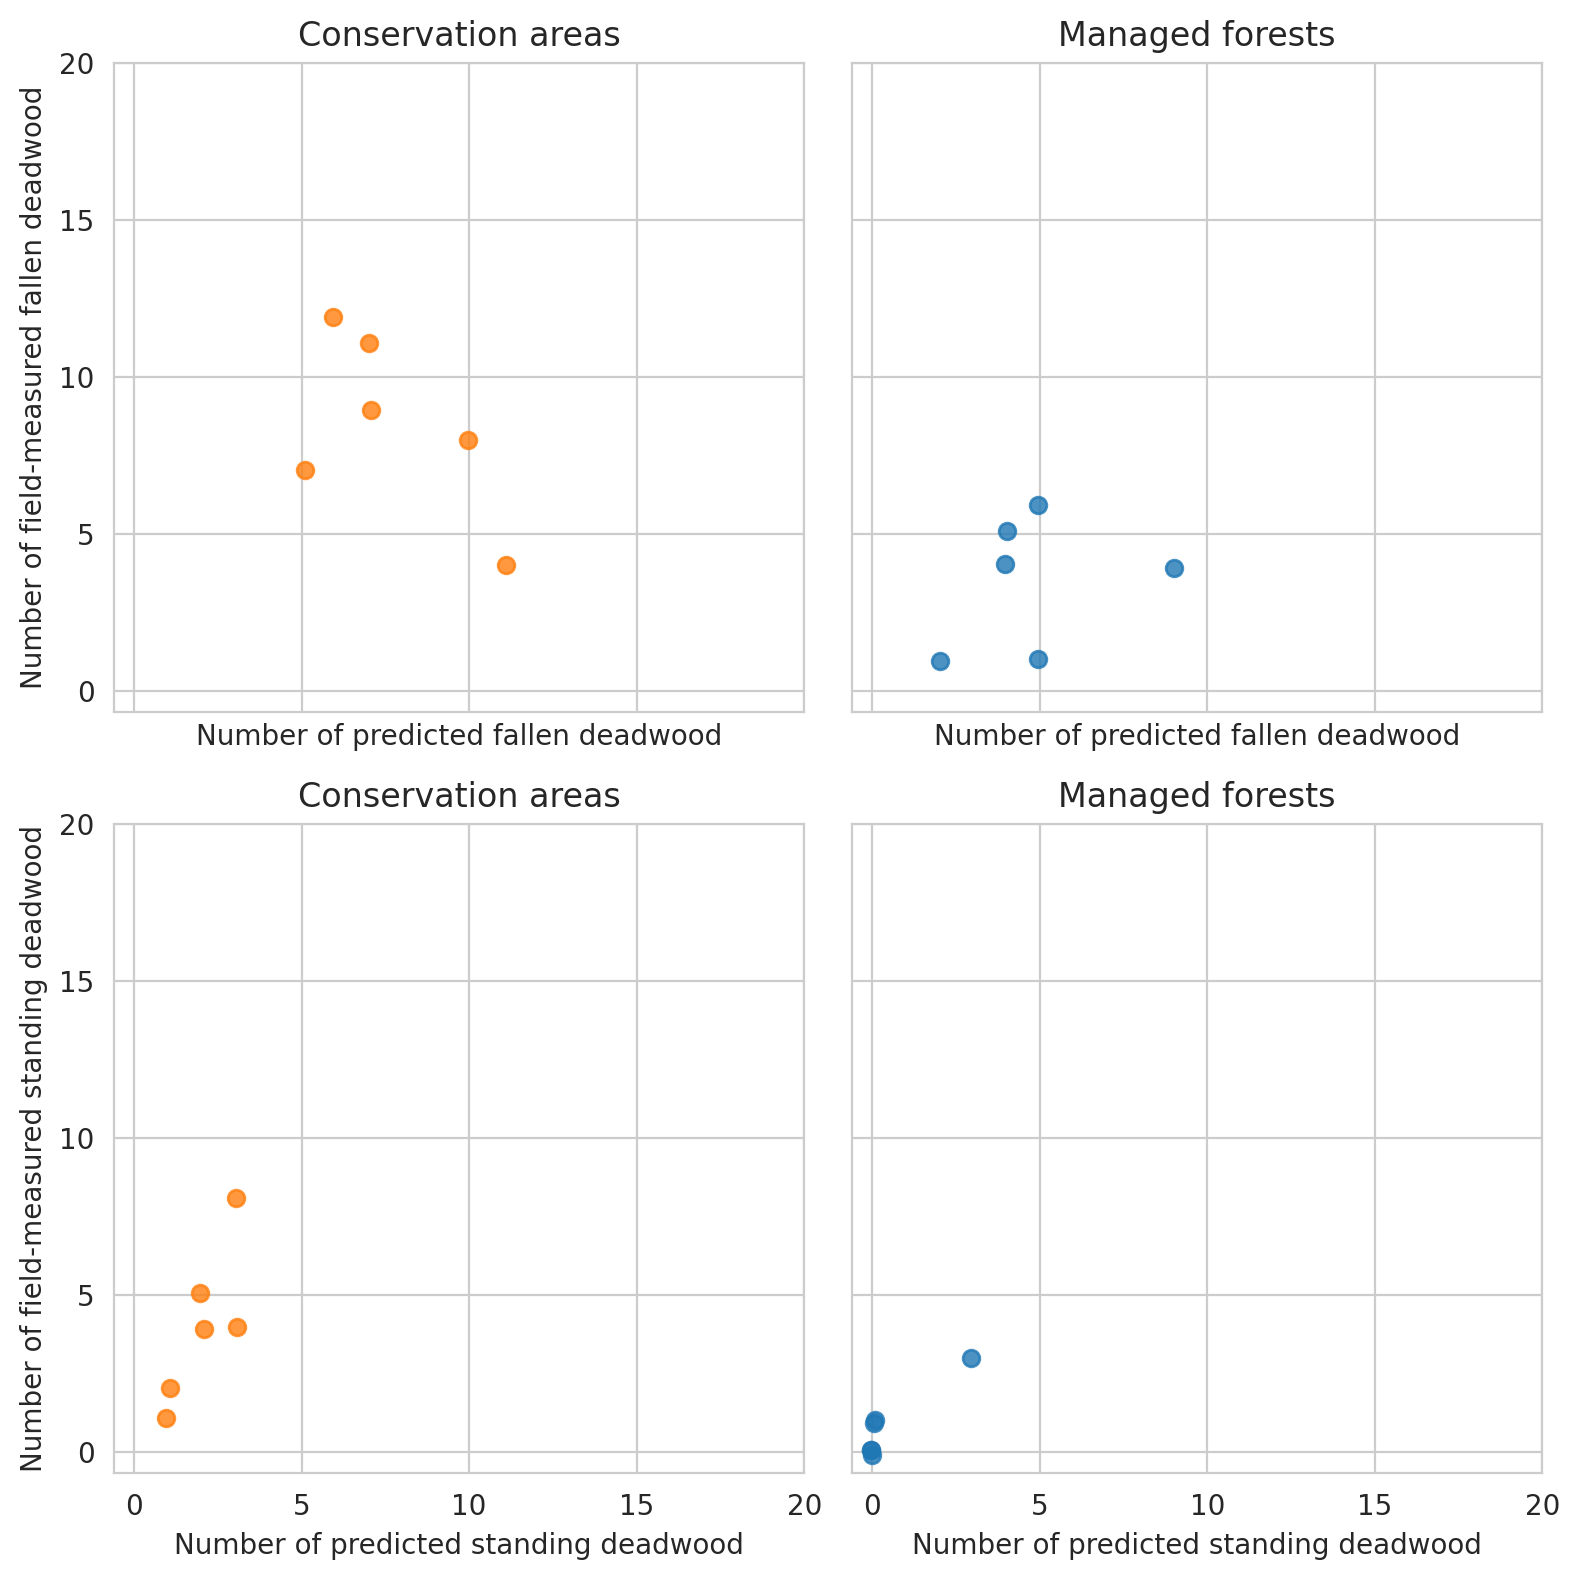

In [36]:
fig, ax = plt.subplots(2,2, figsize=(8,8), dpi=200, sharey=True, sharex=True)
sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 1)], fit_reg=False, 
            x='n_ddw_pred', y='n_ddw_plot', ax=ax[0,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[0,0].set_title('Conservation areas')
ax[0,0].set_yticks(range(0,21,5))
ax[0,0].set_yticklabels(range(0,21,5))
ax[0,0].set_xticks(range(0,21,5))
ax[0,0].set_xticklabels(range(0,21,5))
ax[0,0].set_xlabel('Number of predicted fallen deadwood')
ax[0,0].set_ylabel('Number of field-measured fallen deadwood')
sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 0)], fit_reg=False, 
            x='n_ddw_pred', y='n_ddw_plot', ax=ax[0,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[0,1].set_title('Managed forests')
ax[0,1].set_yticks(range(0,21,5))
ax[0,1].set_yticklabels(range(0,21,5))
ax[0,1].set_xticks(range(0,21,5))
ax[0,1].set_xticklabels(range(0,21,5))
ax[0,1].set_xlabel('Number of predicted fallen deadwood')
ax[0,1].set_ylabel('')


sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 1)], fit_reg=False, 
            x='n_udw_pred', y='n_udw_plot', ax=ax[1,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[1,0].set_title('Conservation areas')
ax[1,0].set_xlabel('Number of predicted standing deadwood')
ax[1,0].set_ylabel('Number of field-measured standing deadwood')
ax[1,0].set_yticks(range(0,21,5))
ax[1,0].set_yticklabels(range(0,21,5))
ax[1,0].set_xticks(range(0,21,5))
ax[1,0].set_xticklabels(range(0,21,5))
sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 0)], fit_reg=False, 
            x='n_udw_pred', y='n_udw_plot', ax=ax[1,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[1,1].set_title('Managed forests')
ax[1,1].set_xlabel('Number of predicted standing deadwood')
ax[1,1].set_ylabel('')
ax[1,1].set_yticks(range(0,21,5))
ax[1,1].set_yticklabels(range(0,21,5))
ax[1,1].set_xticks(range(0,21,5))
ax[1,1].set_xticklabels(range(0,21,5))
plt.tight_layout()

Read individual tree measurements, and convert `l` from decimeters to meters.

In [37]:
tree_data = pd.read_csv(field_data_path/'hiidenportti_singletree.csv')
tree_data = tree_data[tree_data.plot_id.isin(plot_dw_data.id.unique())]
tree_data['l'] /= 10

Add information about conservation area to tree data.

In [38]:
tree_data['conservation'] = tree_data.apply(lambda row: plot_dw_data[plot_dw_data.id == row.plot_id].conservation.unique()[0], axis=1)

In [39]:
preds_in_plots['conservation'] = preds_in_plots.apply(lambda row: plot_dw_data[plot_dw_data.id == row.plot_id].conservation.unique()[0], axis=1)

In [40]:
anns_in_plots['tree_length'] = anns_in_plots.apply(lambda row: get_len_in_plot(row.geometry, plot_circles), axis=1)
preds_in_plots['tree_length'] = preds_in_plots.apply(lambda row: get_len_in_plot(row.geometry, plot_circles), axis=1)

Compare the distributions of the downed trunk lengths. Both graphs only take the parts within the plots into account. Lengths are binned into 1m bins.

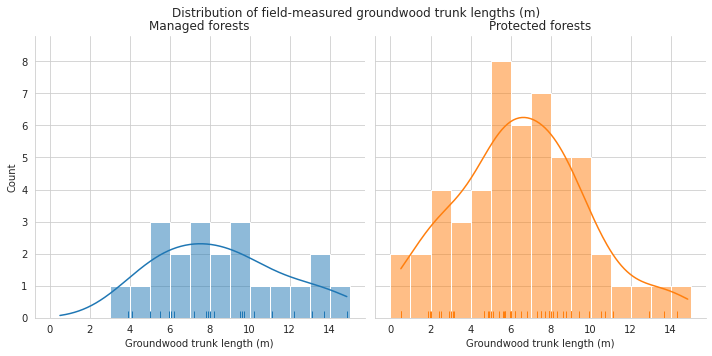

In [41]:
g = sns.displot(data=tree_data[(tree_data.tree_class == 4)&(tree_data.l > 0)], x='l', 
                hue='conservation', col='conservation'
                ,kde=True, rug=True, legend=False, binwidth=1, binrange=(0, max(tree_data[tree_data.tree_class == 4].l))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of field-measured groundwood trunk lengths (m)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk length (m)')
plt.show()

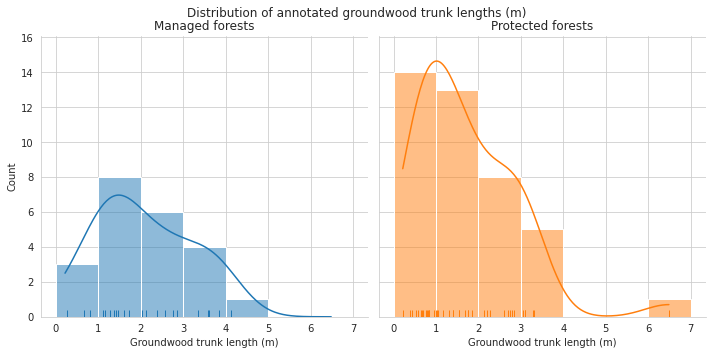

In [42]:
g = sns.displot(data=anns_in_plots[anns_in_plots.layer=='groundwood'], x='tree_length',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=1, binrange=(0, max(anns_in_plots.tree_length))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood trunk lengths (m)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk length (m)')
plt.show()

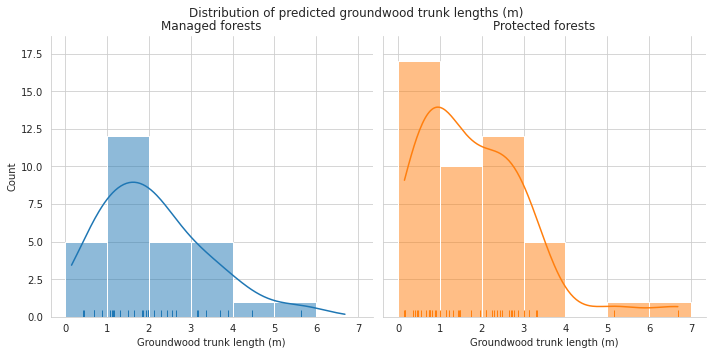

In [43]:
g = sns.displot(data=preds_in_plots[preds_in_plots.layer=='groundwood'], x='tree_length',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=1, binrange=(0, max(preds_in_plots.tree_length))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of predicted groundwood trunk lengths (m)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk length (m)')
plt.show()

As expected, annotated trunks are clearly on average shorter than field measured.

Compare the measured DBH for downed trees and estimated diameter of annotated downed deadwood. For annotated deadwood, the diameter is estimated for the whole tree, not only for the part within the field plot. DBHs are binned into 50mm bins.

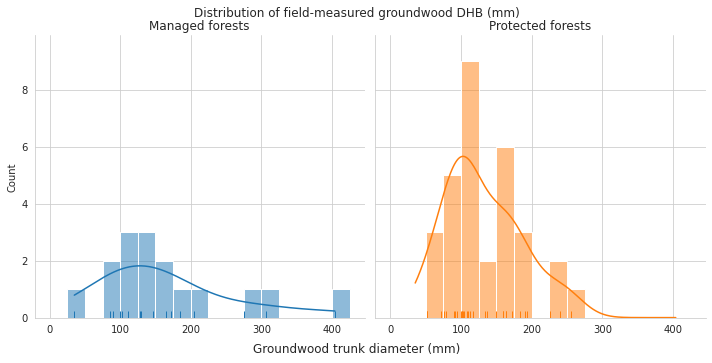

In [44]:
g = sns.displot(data=tree_data[(tree_data.tree_class == 4)&(tree_data.dbh>0)], x='dbh', hue='conservation', 
                col='conservation', kde=True, rug=True, legend=False, binwidth=25,
                binrange=(0, max(tree_data[(tree_data.tree_class == 4)].dbh))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of field-measured groundwood DHB (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('','')
g.fig.supxlabel('Groundwood trunk diameter (mm)')
plt.show()

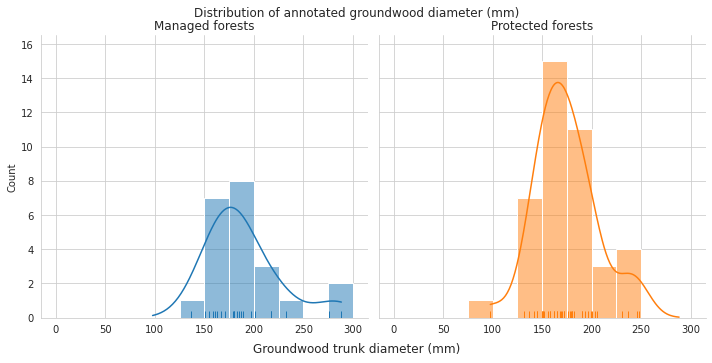

In [45]:
anns_in_plots['diam'] = anns_in_plots.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000
g = sns.displot(data=anns_in_plots[(anns_in_plots.layer=='groundwood')], x='diam',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=25, binrange=(0, max(anns_in_plots[(anns_in_plots.layer=='groundwood')].diam)))
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood diameter (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('','')
g.fig.supxlabel('Groundwood trunk diameter (mm)')
plt.show()

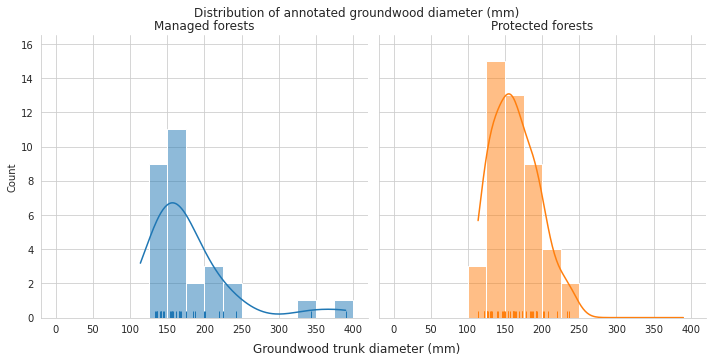

In [46]:
preds_in_plots['diam'] = preds_in_plots.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000
g = sns.displot(data=preds_in_plots[(preds_in_plots.layer=='groundwood')], x='diam',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=25, binrange=(0, max(preds_in_plots[(preds_in_plots.layer=='groundwood')].diam)))
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood diameter (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('','')
g.fig.supxlabel('Groundwood trunk diameter (mm)')
plt.show()

In [117]:
pd.pivot_table(data=tree_data[(tree_data.tree_class == 4)&(tree_data.dbh>0)],
               index=['conservation'], values=['l', 'dbh'],
               aggfunc=['mean', 'min', 'max'], margins=True)

mean           min            max         
                     dbh         l dbh         l  dbh        l
conservation                                                  
0             165.000000  8.735392  35  3.904953  404  13.7169
1             131.806452  7.387939  51  1.866795  255  13.6500
All           143.106383  7.846646  35  1.866795  404  13.7169

In [116]:
pd.pivot_table(data=anns_in_plots[anns_in_plots.groundwood==2], index=['conservation'], values=['tree_length', 'diam'],
               aggfunc=['mean', 'min', 'max'], margins=True)

mean                     min                     max  \
                    diam tree_length        diam tree_length        diam   
conservation                                                               
0             189.604763    2.095525  136.503368    0.261448  288.216786   
1             174.181904    1.712194   97.691220    0.217127  247.809762   
All           179.567664    1.846056   97.691220    0.217127  288.216786   

                          
             tree_length  
conservation              
0               4.126983  
1               6.485503  
All             6.485503

In [112]:
pd.pivot_table(data=preds_in_plots[preds_in_plots.label==2], index=['conservation'], values=['tree_length', 'diam'],
               aggfunc=['mean', 'min', 'max'], margins=True)

mean                     min                     max  \
                    diam tree_length        diam tree_length        diam   
conservation                                                               
0             180.330085    2.108754  133.890527     0.42717  390.030667   
1             163.280782    1.776469  113.803391     0.15072  235.630111   
All           169.873179    1.904952  113.803391     0.15072  390.030667   

                          
             tree_length  
conservation              
0               5.647587  
1               6.686645  
All             6.686645

In [50]:
anns_in_plots['v_ddw'] = anns_in_plots.geometry.apply(cut_cone_volume)

In [51]:
plot_dw_data['v_ddw_ann'] = plot_dw_data.apply(lambda row: anns_in_plots[(anns_in_plots.plot_id == row.id) &
                                                                        (anns_in_plots.layer == 'groundwood')
                                                                       ].v_ddw.sum()
                                              , axis=1)

In [52]:
preds_in_plots['v_ddw'] = preds_in_plots.geometry.apply(cut_cone_volume)
plot_dw_data['v_ddw_pred'] = plot_dw_data.apply(lambda row: preds_in_plots[(preds_in_plots.plot_id == row.id) &
                                                                        (preds_in_plots.layer == 'groundwood')
                                                                       ].v_ddw.sum()
                                              , axis=1)

In [53]:
plot_dw_data['v_dw_plot'] = (plot_dw_data['v_dw']/10000)*np.pi*9**2
plot_dw_data['v_ddw_plot'] = (plot_dw_data['v_ddw']/10000)*np.pi*9**2
plot_dw_data['v_udw_plot'] = plot_dw_data.v_dw_plot - plot_dw_data.v_ddw_plot

In [54]:
pd.pivot_table(data=plot_dw_data, index=['conservation'], values=['v_ddw'],
               aggfunc=['min', 'max', 'mean', 'median','std', 'count'], margins=True)

,min,max,mean,median,std,count
,v_ddw,v_ddw,v_ddw,v_ddw,v_ddw,v_ddw
conservation,,,,,,
0,1.476682,88.948335,31.362157,23.047994,34.526304,6
1,11.019677,44.052516,27.105068,28.626148,13.403048,6
All,1.476682,88.948335,29.233612,28.626148,25.068824,12


In [56]:
plot_dw_data['v_ddw_ann_ha'] = (10000 * plot_dw_data.v_ddw_ann) / (np.pi * 9**2)

pd.pivot_table(data=plot_dw_data, index=['conservation'], values=['v_ddw_ann_ha'],
               aggfunc=['min', 'max', 'mean', 'median','std', 'count'], margins=True)

,min,max,mean,median,std,count
,v_ddw_ann_ha,v_ddw_ann_ha,v_ddw_ann_ha,v_ddw_ann_ha,v_ddw_ann_ha,v_ddw_ann_ha
conservation,,,,,,
0,3.946787,40.793841,16.320077,12.080675,14.120999,6
1,7.751047,24.516270,16.879035,17.353505,6.154216,6
All,3.946787,40.793841,16.599556,15.850944,10.389340,12


In [57]:
plot_dw_data['v_ddw_pred_ha'] = (10000 * plot_dw_data.v_ddw_pred) / (np.pi * 9**2)

pd.pivot_table(data=plot_dw_data, index=['conservation'], values=['v_ddw_pred_ha'],
               aggfunc=['min', 'max', 'mean', 'median','std', 'count'], margins=True)

,min,max,mean,median,std,count
,v_ddw_pred_ha,v_ddw_pred_ha,v_ddw_pred_ha,v_ddw_pred_ha,v_ddw_pred_ha,v_ddw_pred_ha
conservation,,,,,,
0,5.073579,78.846897,27.011548,10.171078,30.405554,6
1,6.916883,28.824690,19.043036,18.786666,8.273489,6
All,5.073579,78.846897,23.027292,15.094789,21.648500,12


# Sudenpesänkangas

Read data and do some wrangling.

In [58]:
evo_fd_path = Path('../data/sudenpesankangas/')
evo_anns = gpd.read_file('../../data/raw/sudenpesankangas/virtual_plots/sudenpesankangas_deadwood.geojson')
evo_anns = evo_anns.to_crs('epsg:3067')
evo_preds = gpd.read_file('../results/sudenpesankangas/spk_merged.geojson')
evo_plot_circles = gpd.read_file(evo_fd_path/'plot_circles.geojson')
evo_plot_circles['id'] = evo_plot_circles['id'].astype(int)
evo_natura = gpd.read_file(evo_fd_path/'sudenpesankangas_natura.geojson')
evo_field_data = pd.read_csv(evo_fd_path/'puutiedot_sudenpesänkangas.csv', sep=';', decimal=',')
evo_field_data = gpd.GeoDataFrame(evo_field_data, geometry=gpd.points_from_xy(evo_field_data.gx, evo_field_data.gy), 
                                   crs='epsg:3067')
evo_grid = gpd.read_file(evo_fd_path/'vplots.geojson')
evo_grid = evo_grid.to_crs('epsg:3067')
evo_field_data['plotid'] = evo_field_data.kaid + 1000
evo_field_data = evo_field_data[evo_field_data.puuluo.isin([3,4])]

In [59]:
def match_plotid_spk(geom, plots):
    for r in plots.itertuples():
        if r.geometry.intersects(geom):
            return r.id
    return None

def match_vplot_spk(geom, plots):
    for p in plots.itertuples():
        if geom.intersects(p.geometry):
            return f'{p.fid}_{int(p.id)}'

Get up-to-date field data

In [60]:
evo_plots_updated = pd.read_csv(evo_fd_path/'Koealatunnukset_Evo_2018.txt', sep=' ')
evo_plots_luke = pd.read_csv(evo_fd_path/'Koealatunnukset_Evo_2018_LUKE.txt', sep=' ')
evo_plots_updated = gpd.GeoDataFrame(evo_plots_updated, geometry=gpd.points_from_xy(evo_plots_updated.x,
                                                                                    evo_plots_updated.y),
                                     crs='epsg:3067')
evo_plots_luke = gpd.GeoDataFrame(evo_plots_luke, geometry=gpd.points_from_xy(evo_plots_luke.x,
                                                                              evo_plots_luke.y),
                                     crs='epsg:3067')
evo_plots = pd.concat([evo_plots_updated, evo_plots_luke])
evo_plots.rename(columns= {c: c.replace('.','_') for c in evo_plots.columns}, inplace=True)

In [61]:
evo_plots['spk_id'] = evo_plots.geometry.apply(lambda row: match_plotid_spk(row, evo_plot_circles))

In [62]:
evo_plots.dropna(subset='spk_id', inplace=True)

In [63]:
evo_plots['geometry'] = evo_plots.spk_id.apply(lambda row: evo_plot_circles[evo_plot_circles.id == row].geometry.iloc[0])

In [64]:
evo_plots.drop(columns=['id'], inplace=True)
evo_plots.rename(columns={'spk_id': 'id'}, inplace=True)

In [65]:
evo_plots['conservation'] = evo_plots.geometry.apply(lambda row: 1 if evo_natura.geometry.unary_union.intersects(row)
                                                     else 0)

In [66]:
evo_anns['plot_id'] = evo_anns.apply(lambda row: int(row.vplot_id.split('_')[1]), axis=1)

In [67]:
evo_plots = evo_plots[evo_plots.id.isin(evo_anns.plot_id.unique())]

In [68]:
evo_anns['plot_id'] = evo_anns.apply(lambda row: match_circular_plot(row, evo_plots), axis=1)
evo_anns_in_plots = evo_anns[evo_anns.geometry.intersects(evo_plots.geometry.unary_union)].copy()

In [69]:
evo_preds['conservation'] = evo_preds.geometry.apply(lambda row: 1 if any(evo_natura.geometry.contains(row))
                                                         else 0)

In [70]:
evo_preds['vplot_id'] = evo_preds.geometry.apply(lambda row: match_vplot_spk(row, evo_grid))
evo_preds['plot_id'] = evo_preds.apply(lambda row: match_circular_plot(row, evo_plots), axis=1)
evo_preds_in_plots = evo_preds[evo_preds.geometry.intersects(evo_plots.geometry.unary_union)].copy()
evo_preds_in_plots['plot_id'] = evo_preds_in_plots.plot_id.astype(int)

## Predictions vs annotations, all available data

In [71]:
pd.crosstab(evo_anns.conservation, evo_anns.label, margins=True)

label,groundwood,uprightwood,All
conservation,,,
0,569,61,630
1,3346,1358,4704
All,3915,1419,5334


In [72]:
pd.crosstab(evo_preds.conservation, evo_preds.layer, margins=True)

layer,groundwood,uprightwood,All
conservation,,,
0,583,77,660
1,3890,1235,5125
All,4473,1312,5785


In [73]:
evo_anns['tree_length'] = evo_anns.geometry.apply(get_len)
evo_preds['tree_length'] = evo_preds.geometry.apply(get_len)
evo_anns['diam'] = evo_anns.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000
evo_preds['diam'] = evo_preds.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000

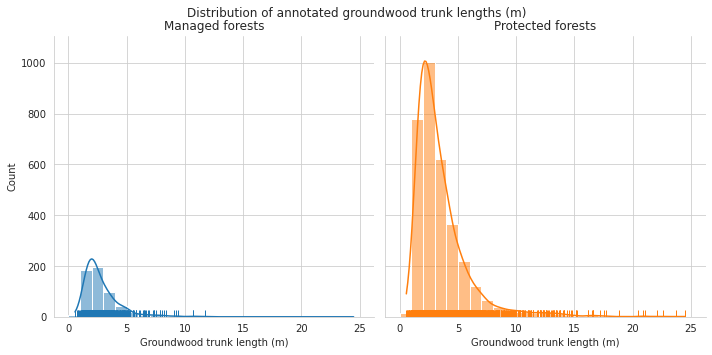

In [74]:
g = sns.displot(data=evo_anns[evo_anns.label=='groundwood'], x='tree_length',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=1, binrange=(0, max(evo_anns.tree_length))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood trunk lengths (m)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk length (m)')
plt.show()

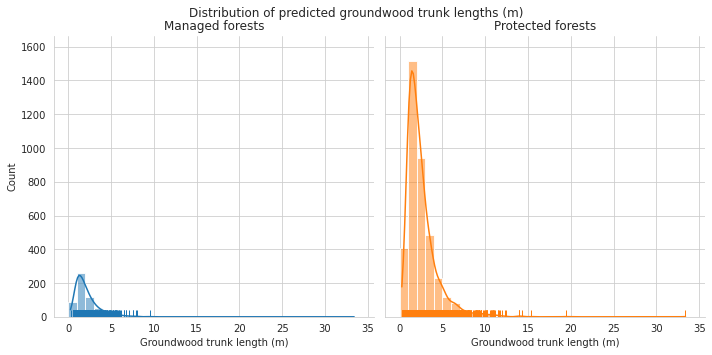

In [75]:
g = sns.displot(data=evo_preds[evo_preds.layer=='groundwood'], x='tree_length',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=1, binrange=(0, max(evo_preds.tree_length))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of predicted groundwood trunk lengths (m)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk length (m)')
plt.show()

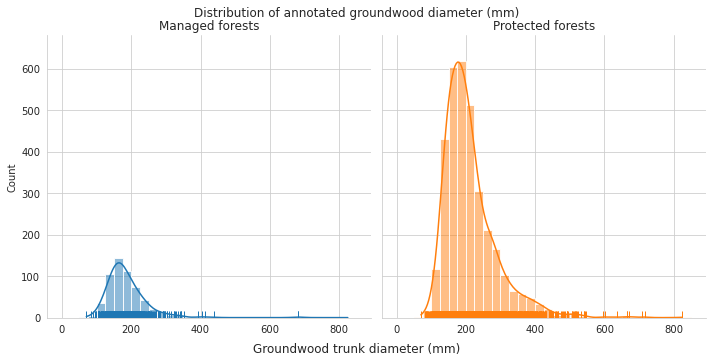

In [76]:
g = sns.displot(data=evo_anns[(evo_anns.label=='groundwood')], x='diam',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=25, binrange=(0, max(evo_anns[(evo_anns.label=='groundwood')].diam)))
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood diameter (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('','')
g.fig.supxlabel('Groundwood trunk diameter (mm)')
plt.show()

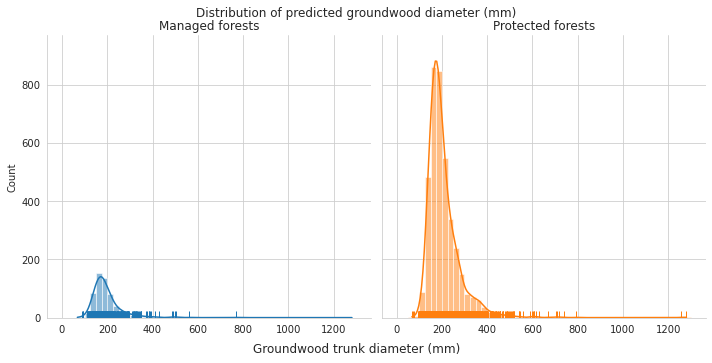

In [77]:
g = sns.displot(data=evo_preds[(evo_preds.layer=='groundwood')], x='diam',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=25, binrange=(0, max(evo_preds[(evo_preds.layer=='groundwood')].diam)))
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of predicted groundwood diameter (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('','')
g.fig.supxlabel('Groundwood trunk diameter (mm)')
plt.show()

In [110]:
evo_anns[evo_anns.label=='groundwood'].pivot_table(index='conservation', values=['diam', 'tree_length'], 
                                       margins=True, aggfunc=['mean', 'min', 'max'])

mean                    min                     max  \
                    diam tree_length       diam tree_length        diam   
conservation                                                              
0             185.017164    2.810096  70.133069    0.605847  682.194784   
1             211.999284    3.534998  71.701478    0.575351  825.308495   
All           208.077744    3.429642  70.133069    0.575351  825.308495   

                          
             tree_length  
conservation              
0              11.732769  
1              24.479043  
All            24.479043

In [109]:
evo_preds[evo_preds.layer=='groundwood'].pivot_table(index='conservation', values=['diam', 'tree_length'], 
                                           margins=True, aggfunc=['mean', 'min', 'max'])

mean                    min                      max  \
                    diam tree_length       diam tree_length         diam   
conservation                                                               
0             195.384340    2.158607  86.960248    0.364386   766.706344   
1             206.642082    2.523641  67.504545    0.261644  1280.594783   
All           205.174775    2.476063  67.504545    0.261644  1280.594783   

                          
             tree_length  
conservation              
0               9.523242  
1              33.394250  
All            33.394250

In [80]:
evo_anns['area_m2'] = evo_anns.geometry.area
evo_preds['area_m2'] = evo_preds.geometry.area

In [81]:
evo_anns[evo_anns.label=='uprightwood'].pivot_table(index='conservation', values=['area_m2'], margins=True,
                                                    aggfunc=['mean', 'sum'])

,mean,sum
,area_m2,area_m2
conservation,,
0,3.607135,220.035256
1,5.151703,6996.012763
All,5.085305,7216.048018


In [82]:
evo_preds[evo_preds.layer=='uprightwood'].pivot_table(index='conservation', values=['area_m2'], margins=True,
                                                      aggfunc=['mean', 'sum'])

,mean,sum
,area_m2,area_m2
conservation,,
0,3.033578,233.585538
1,5.334382,6587.961502
All,5.199350,6821.547040


In [83]:
evo_anns['v_ddw'] = evo_anns.geometry.apply(cut_cone_volume)
evo_preds['v_ddw'] = evo_preds.geometry.apply(cut_cone_volume)

In [84]:
evo_vplot_area = evo_grid.area.sum()
evo_cons_area = evo_natura.overlay(evo_grid).area.sum()
evo_man_area = evo_vplot_area - evo_cons_area
evo_man_ha = evo_man_area / 10000
evo_cons_ha = evo_cons_area / 10000

In [85]:
evo_ann_est_v_man = evo_anns[(evo_anns.label=='groundwood')&(evo_anns.conservation==0)].v_ddw.sum()/evo_man_ha
evo_ann_est_v_cons = evo_anns[(evo_anns.label=='groundwood')&(evo_anns.conservation==1)].v_ddw.sum()/evo_cons_ha
evo_ann_est_v = evo_anns[(evo_anns.label=='groundwood')].v_ddw.sum()/(evo_vplot_area/10000)

In [86]:
evo_pred_est_v_man = evo_preds[(evo_preds.layer=='groundwood')&(evo_preds.conservation==0)].v_ddw.sum()/evo_man_ha
evo_pred_est_v_cons = evo_preds[(evo_preds.layer=='groundwood')&(evo_preds.conservation==1)].v_ddw.sum()/evo_cons_ha
evo_pred_est_v = evo_preds[(evo_preds.layer=='groundwood')].v_ddw.sum()/(evo_vplot_area/10000)

In [87]:
print(f'Estimated groundwood volume in managed forests, based on annotations: {evo_ann_est_v_man:.2f} ha/m³')
print(f'Estimated groundwood volume in conserved forests, based on annotations: {evo_ann_est_v_cons:.2f} ha/m³')
print(f'Estimated groundwood volume in both types, based on annotations: {evo_ann_est_v:.2f} ha/m³')

Estimated groundwood volume in managed forests, based on annotations: 4.46 ha/m³
Estimated groundwood volume in conserved forests, based on annotations: 10.67 ha/m³
Estimated groundwood volume in both types, based on annotations: 9.47 ha/m³


In [88]:
print(f'Estimated groundwood volume in managed forests, based on predictions: {evo_pred_est_v_man:.2f} ha/m³')
print(f'Estimated groundwood volume in conserved forests, based on predictions: {evo_pred_est_v_cons:.2f} ha/m³')
print(f'Estimated groundwood volume in both types, based on predictions: {evo_pred_est_v:.2f} ha/m³')

Estimated groundwood volume in managed forests, based on predictions: 4.41 ha/m³
Estimated groundwood volume in conserved forests, based on predictions: 10.75 ha/m³
Estimated groundwood volume in both types, based on predictions: 9.52 ha/m³


## Predictions vs field data, plot-wise

Add canopy density based on LiDAR derived canopy height model. The density is the percentage of field plot area with height above 2 meters.

In [89]:
pcts = []

with rio.open('../../data/raw/sudenpesankangas/full_mosaics/sudenpesankangas_chm.tif') as src:
    for row in evo_plots.itertuples():
        plot_im, plot_tfm = rio_mask.mask(src, [row.geometry], crop=True)
        pcts.append(plot_im[plot_im > 2].shape[0] / plot_im[plot_im >= 0].shape[0])

In [90]:
evo_plots['canopy_cover_pct'] = pcts

In [91]:
pd.pivot_table(data=evo_plots, index=['conservation'], values=['canopy_cover_pct'],
               aggfunc=['min', 'max', 'mean', 'std', 'count'], margins=True)

,min,max,mean,std,count
,canopy_cover_pct,canopy_cover_pct,canopy_cover_pct,canopy_cover_pct,canopy_cover_pct
conservation,,,,,
0,0.237288,0.959839,0.676011,0.264467,14
1,0.491036,0.991992,0.853076,0.113649,57
All,0.237288,0.991992,0.818162,0.168393,71


Count the number of deadwood instances similarly as for Hiidenportti data and plot the relationship between them.

In [92]:
evo_plots['n_dw_ann'] = evo_plots.apply(lambda row: evo_anns.plot_id.value_counts()[int(row.id)]
                                        if row.id in evo_anns.plot_id.unique() else 0, axis=1)
evo_plots['n_ddw_ann'] = evo_plots.apply(lambda row: evo_anns[evo_anns.label=='groundwood'].plot_id.value_counts()[int(row.id)]
                                        if row.id in evo_anns[evo_anns.label=='groundwood'].plot_id.unique() else 0, axis=1)
evo_plots['n_udw_ann'] = evo_plots.apply(lambda row: evo_anns[evo_anns.label!='groundwood'].plot_id.value_counts()[int(row.id)]
                                        if row.id in evo_anns[evo_anns.label!='groundwood'].plot_id.unique() else 0, axis=1)

evo_plots['n_dw_plot'] = np.round((evo_plots['n_dw']/10000)*np.pi*9**2).astype(int)
evo_plots['n_ddw_plot'] = np.round((evo_plots['n_ddw']/10000)*np.pi*9**2).astype(int)
evo_plots['n_udw_plot'] = evo_plots.n_dw_plot - evo_plots.n_ddw_plot
evo_plots['conservation'] = evo_plots.apply(lambda row: 1 if any(evo_natura.geometry.contains(row.geometry))
                                                        else 0, axis=1)

In [93]:
evo_plots['n_dw_pred'] = evo_plots.apply(lambda row: evo_preds.plot_id.value_counts()[int(row.id)]
                                        if row.id in evo_preds.plot_id.unique() else 0, axis=1)
evo_plots['n_ddw_pred'] = evo_plots.apply(lambda row: evo_preds[evo_preds.layer=='groundwood'].plot_id.value_counts()[int(row.id)]
                                        if row.id in evo_preds[evo_preds.layer=='groundwood'].plot_id.unique() else 0, axis=1)
evo_plots['n_udw_pred'] = evo_plots.apply(lambda row: evo_preds[evo_preds.layer!='groundwood'].plot_id.value_counts()[int(row.id)]
                                        if row.id in evo_preds[evo_preds.layer!='groundwood'].plot_id.unique() else 0, axis=1)



In [94]:
evo_plots.pivot_table(index='conservation', values=['n_ddw_plot', 'n_udw_plot', 'n_ddw_ann', 'n_udw_ann', 
                                                    'n_ddw_pred', 'n_udw_pred'], 
                         aggfunc='sum', margins=True)

,n_ddw_ann,n_ddw_plot,n_ddw_pred,n_udw_ann,n_udw_plot,n_udw_pred
conservation,,,,,,
0,22,3,15,8,15,9
1,65,40,87,35,145,36
All,87,43,102,43,160,45


Plot the relationship between annotated and field data.

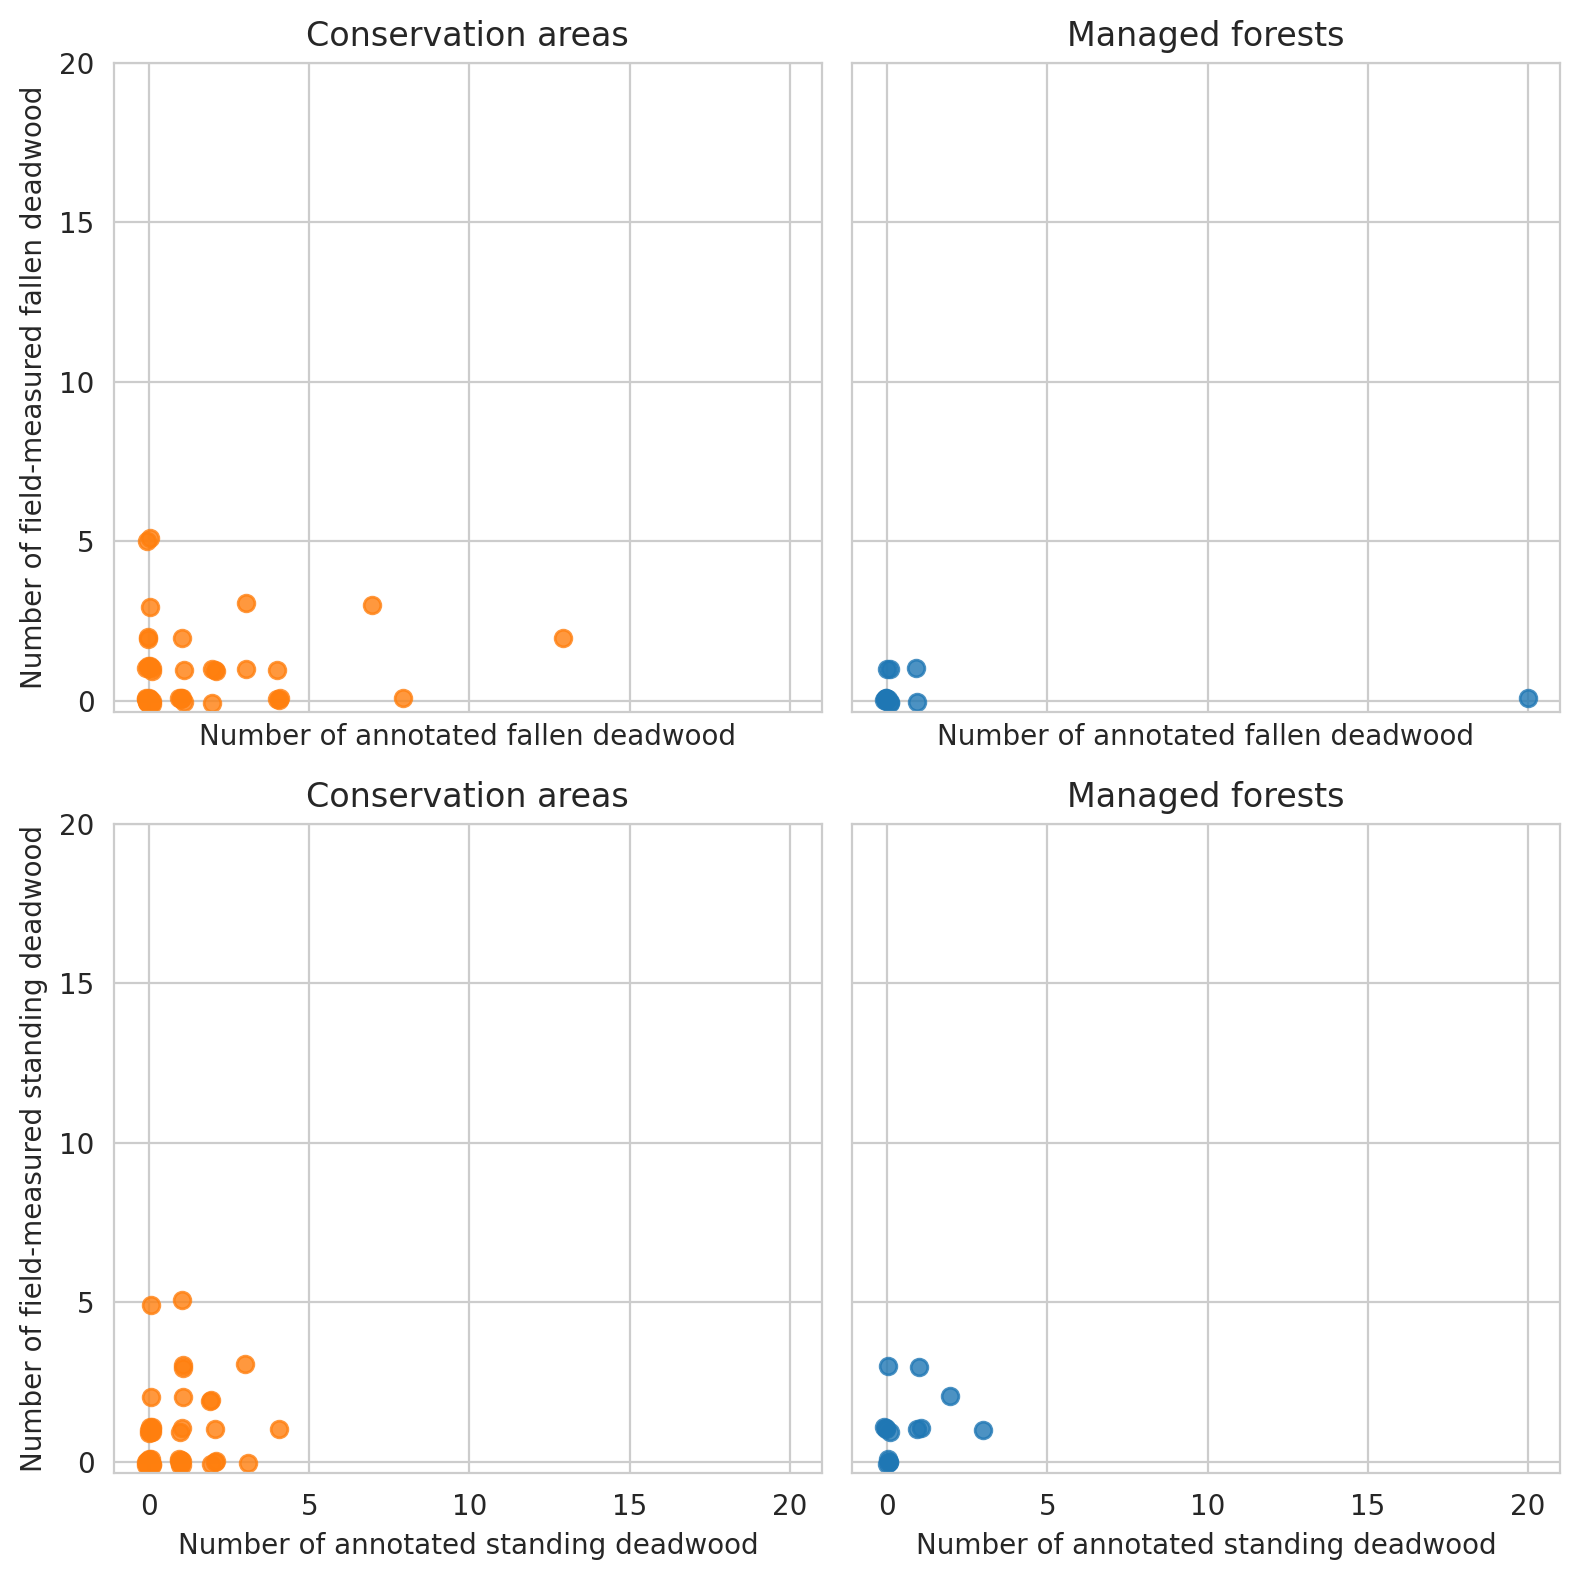

In [95]:
fig, ax = plt.subplots(2,2, figsize=(8,8), dpi=200, sharey=True, sharex=True)
sns.regplot(data=evo_plots[(evo_plots.conservation == 1)], fit_reg=False, 
            x='n_ddw_ann', y='n_ddw_plot', ax=ax[0,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[0,0].set_title('Conservation areas')
ax[0,0].set_yticks(range(0,21,5))
ax[0,0].set_yticklabels(range(0,21,5))
ax[0,0].set_xlabel('Number of annotated fallen deadwood')
ax[0,0].set_ylabel('Number of field-measured fallen deadwood')
sns.regplot(data=evo_plots[(evo_plots.conservation == 0)], fit_reg=False, 
            x='n_ddw_ann', y='n_ddw_plot', ax=ax[0,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[0,1].set_title('Managed forests')
ax[0,1].set_yticks(range(0,21,5))
ax[0,1].set_yticklabels(range(0,21,5))
ax[0,1].set_xlabel('Number of annotated fallen deadwood')
ax[0,1].set_ylabel('')


sns.regplot(data=evo_plots[(evo_plots.conservation == 1)], fit_reg=False, 
            x='n_udw_ann', y='n_ddw_plot', ax=ax[1,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[1,0].set_title('Conservation areas')
ax[1,0].set_xlabel('Number of annotated standing deadwood')
ax[1,0].set_ylabel('Number of field-measured standing deadwood')
ax[1,0].set_yticks(range(0,21,5))
ax[1,0].set_yticklabels(range(0,21,5))
sns.regplot(data=evo_plots[(evo_plots.conservation == 0)], fit_reg=False, 
            x='n_udw_ann', y='n_udw_plot', ax=ax[1,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[1,1].set_title('Managed forests')
ax[1,1].set_xlabel('Number of annotated standing deadwood')
ax[1,1].set_ylabel('')
ax[1,1].set_yticks(range(0,21,5))
ax[1,1].set_yticklabels(range(0,21,5))
plt.tight_layout()

Same for field data and predictions.

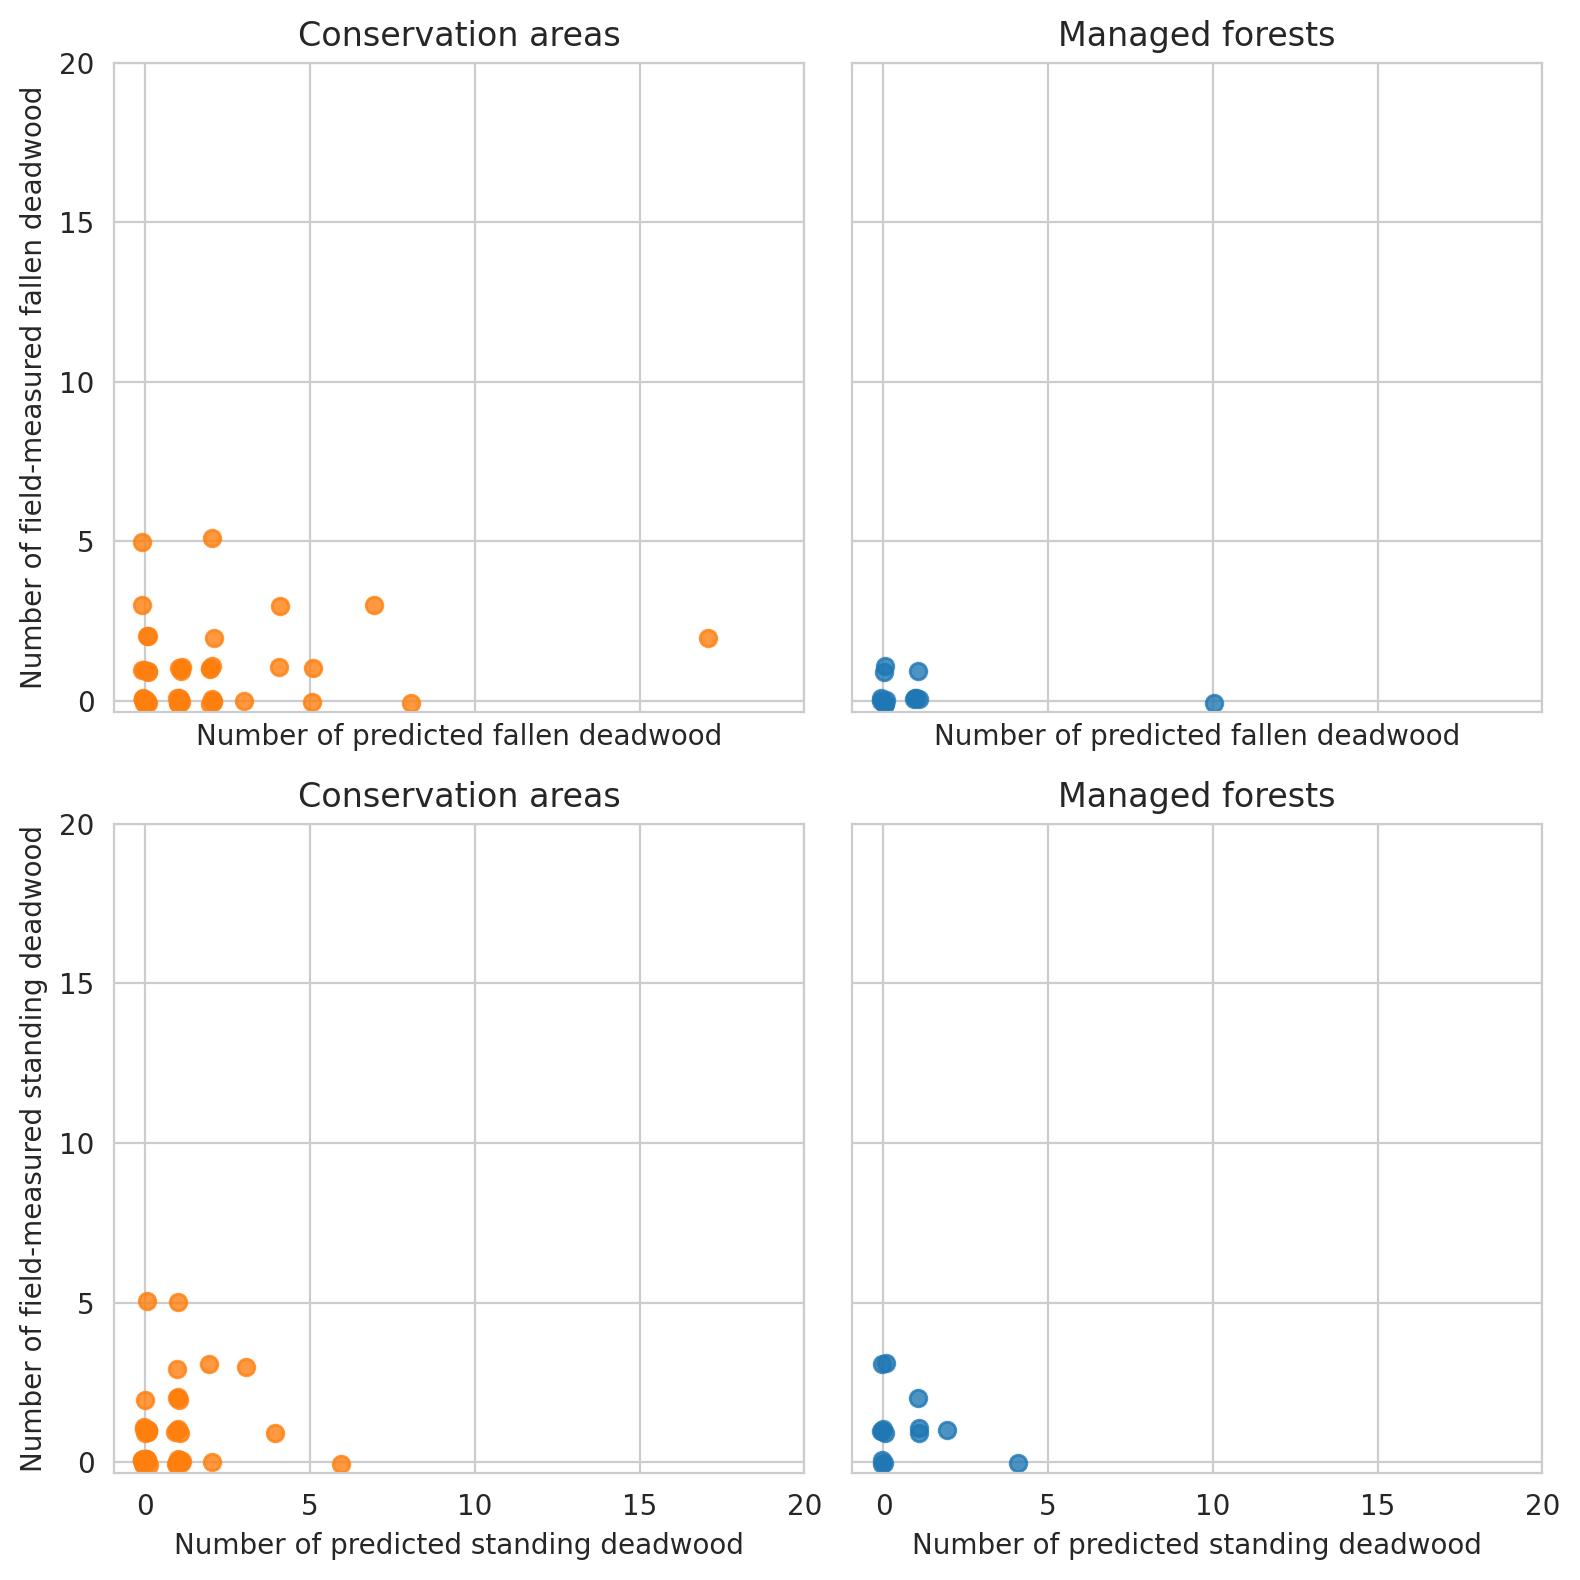

In [96]:
fig, ax = plt.subplots(2,2, figsize=(8,8), dpi=200, sharey=True, sharex=True)
sns.regplot(data=evo_plots[(evo_plots.conservation == 1)], fit_reg=False, 
            x='n_ddw_pred', y='n_ddw_plot', ax=ax[0,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[0,0].set_title('Conservation areas')
ax[0,0].set_yticks(range(0,21,5))
ax[0,0].set_yticklabels(range(0,21,5))
ax[0,0].set_xticks(range(0,21,5))
ax[0,0].set_xticklabels(range(0,21,5))
ax[0,0].set_xlabel('Number of predicted fallen deadwood')
ax[0,0].set_ylabel('Number of field-measured fallen deadwood')
sns.regplot(data=evo_plots[(evo_plots.conservation == 0)], fit_reg=False, 
            x='n_ddw_pred', y='n_ddw_plot', ax=ax[0,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[0,1].set_title('Managed forests')
ax[0,1].set_yticks(range(0,21,5))
ax[0,1].set_yticklabels(range(0,21,5))
ax[0,1].set_xticks(range(0,21,5))
ax[0,1].set_xticklabels(range(0,21,5))
ax[0,1].set_xlabel('Number of predicted fallen deadwood')
ax[0,1].set_ylabel('')


sns.regplot(data=evo_plots[(evo_plots.conservation == 1)], fit_reg=False, 
            x='n_udw_pred', y='n_ddw_plot', ax=ax[1,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[1,0].set_title('Conservation areas')
ax[1,0].set_xlabel('Number of predicted standing deadwood')
ax[1,0].set_ylabel('Number of field-measured standing deadwood')
ax[1,0].set_yticks(range(0,21,5))
ax[1,0].set_yticklabels(range(0,21,5))
ax[1,0].set_xticks(range(0,21,5))
ax[1,0].set_xticklabels(range(0,21,5))
sns.regplot(data=evo_plots[(evo_plots.conservation == 0)], fit_reg=False, 
            x='n_udw_pred', y='n_udw_plot', ax=ax[1,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[1,1].set_title('Managed forests')
ax[1,1].set_xlabel('Number of predicted standing deadwood')
ax[1,1].set_ylabel('')
ax[1,1].set_yticks(range(0,21,5))
ax[1,1].set_yticklabels(range(0,21,5))
ax[1,1].set_xticks(range(0,21,5))
ax[1,1].set_xticklabels(range(0,21,5))
plt.tight_layout()

As Evo data doesn't have field-measured deadwood lengths, we can't plot that relationship. We can, however, plot the DBH distributions, even though Evo dataset only has around 50 downed deadwood with dbh measured.

In [97]:
evo_field_data = evo_field_data[evo_field_data.plotid.isin(evo_plots.id.unique())]

In [98]:
evo_field_data['conservation'] = evo_field_data.apply(lambda row: evo_plots[evo_plots.id == row.plotid].conservation.unique()[0], axis=1)

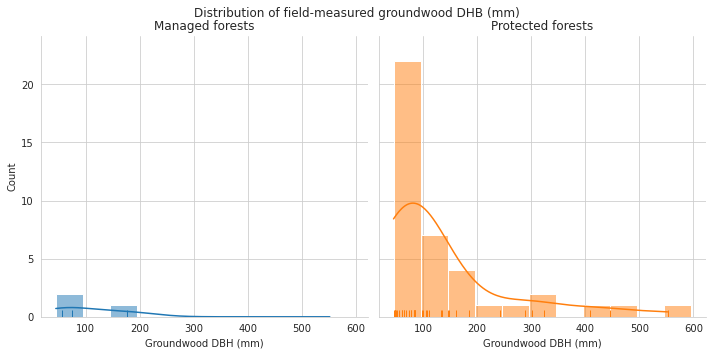

In [99]:
g = sns.displot(data=evo_field_data[(evo_field_data.puuluo == 4)&(evo_field_data.lapimitta_mm>0)], 
                x='lapimitta_mm', hue='conservation', col='conservation'
                ,kde=True, rug=True, legend=False, binwidth=50) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of field-measured groundwood DHB (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood DBH (mm)')
plt.show()

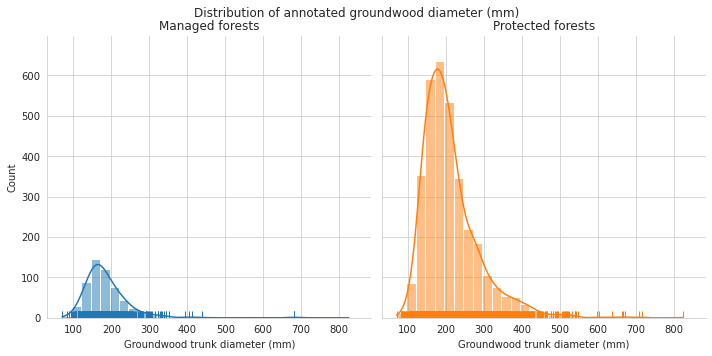

In [100]:
evo_anns_in_plots['diam'] = evo_anns_in_plots.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000
g = sns.displot(data=evo_anns[(evo_anns.label=='groundwood')], x='diam',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, binwidth=25) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood diameter (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk diameter (mm)')
plt.show()

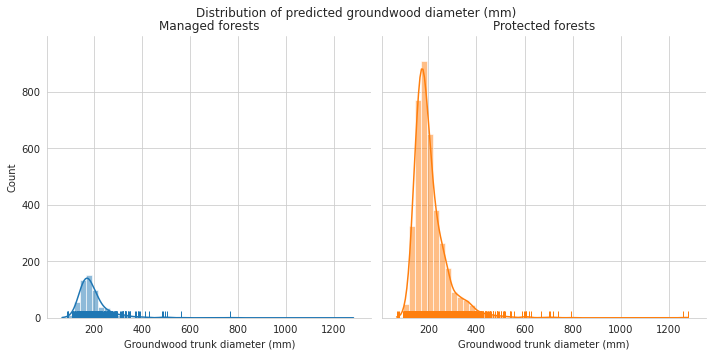

In [101]:
evo_preds_in_plots['diam'] = evo_preds_in_plots.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000
g = sns.displot(data=evo_preds[(evo_preds.layer=='groundwood')], x='diam',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, binwidth=25) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of predicted groundwood diameter (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk diameter (mm)')
plt.show()

In [102]:
evo_anns_in_plots['v_ddw'] = evo_anns_in_plots.geometry.apply(cut_cone_volume)
evo_plots['v_ddw_ann'] = evo_plots.apply(lambda row: evo_anns_in_plots[(evo_anns_in_plots.plot_id == row.id) &
                                                              (evo_anns_in_plots.label == 'groundwood')
                                                              ].v_ddw.sum()
                                              , axis=1)

In [103]:
evo_preds_in_plots['v_ddw'] = evo_preds_in_plots.geometry.apply(cut_cone_volume)
evo_plots['v_ddw_pred'] = evo_plots.apply(lambda row: evo_preds_in_plots[(evo_preds_in_plots.plot_id == row.id) &
                                                              (evo_preds_in_plots.layer == 'groundwood')
                                                              ].v_ddw.sum()
                                              , axis=1)

In [104]:
evo_plots['v_ddw_ann_ha'] = (10000 * evo_plots.v_ddw_ann) / (np.pi * 9**2)
evo_plots['v_ddw_pred_ha'] = (10000 * evo_plots.v_ddw_pred) / (np.pi * 9**2)

In [ ]:
evo_tree_data

In [118]:
evo_preds_in_plots['tree_length'] = evo_preds_in_plots.geometry.apply(get_len)

pd.pivot_table(data=evo_preds_in_plots[evo_preds_in_plots.label==2], index=['conservation'], 
               values=['tree_length', 'diam'],
               aggfunc=['mean', 'min', 'max'], margins=True)

mean                     min                     max  \
                    diam tree_length        diam tree_length        diam   
conservation                                                               
0             189.912383    1.725899  137.198717    0.685994  274.806289   
1             203.571011    2.506923  123.980933    0.675601  515.517234   
All           201.562389    2.392066  123.980933    0.675601  515.517234   

                          
             tree_length  
conservation              
0               2.879036  
1               9.061595  
All             9.061595

In [106]:
pd.pivot_table(data=evo_plots, index=['conservation'], values=['v_ddw'],
               aggfunc=['min', 'max', 'mean', 'median','std', 'count'], margins=True)

,min,max,mean,median,std,count
,v_ddw,v_ddw,v_ddw,v_ddw,v_ddw,v_ddw
conservation,,,,,,
0,0.0,7.873780,0.661535,0.0,2.094276,14
1,0.0,123.004587,7.131762,0.0,23.939949,57
All,0.0,123.004587,5.855943,0.0,21.587804,71


In [107]:
pd.pivot_table(data=evo_plots, index=['conservation'], values=['v_ddw_ann_ha'],
               aggfunc=['min', 'max', 'mean', 'median','std', 'count'], margins=True)

,min,max,mean,median,std,count
,v_ddw_ann_ha,v_ddw_ann_ha,v_ddw_ann_ha,v_ddw_ann_ha,v_ddw_ann_ha,v_ddw_ann_ha
conservation,,,,,,
0,0.0,27.490278,2.644301,0.0,7.355574,14
1,0.0,240.684389,12.333702,0.0,36.917861,57
All,0.0,240.684389,10.423116,0.0,33.398580,71


In [108]:
pd.pivot_table(data=evo_plots, index=['conservation'], values=['v_ddw_pred_ha'],
               aggfunc=['min', 'max', 'mean', 'median','std', 'count'], margins=True)

,min,max,mean,median,std,count
,v_ddw_pred_ha,v_ddw_pred_ha,v_ddw_pred_ha,v_ddw_pred_ha,v_ddw_pred_ha,v_ddw_pred_ha
conservation,,,,,,
0,0.0,20.017281,2.635759,0.000000,5.343824,14
1,0.0,160.855433,8.097544,1.261027,22.710667,57
All,0.0,160.855433,7.020573,1.147933,20.559977,71
